In [ ]:
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin

url = f"https://tastesbetterfromscratch.com/meal-plan-175/"

headers = {
    "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                   "AppleWebKit/537.36 (KHTML, like Gecko) "
                   "Chrome/120.0.0.0 Safari/537.36"),
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.google.com/",
}

resp = requests.get(url, headers=headers, timeout=30)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")

WEEKDAYS = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
price_pat = re.compile(r"\$\s*\d+(?:\.\d{2})?")

rows = []

# pass 1: scan simple blocks (paragraphs and list items)
for block in soup.select("p, li"):
    text = " ".join(block.get_text(" ", strip=True).split())
    if not text:
        continue
    if any(text.startswith(day + ":") for day in WEEKDAYS):
        # day
        day = text.split(":", 1)[0]

        # recipe name + link (first anchor)
        a = block.find("a")
        if not a:
            continue
        name = a.get_text(strip=True)
        link = urljoin(url, a.get("href") or "")

        # price in same line
        m = price_pat.search(text)
        price = m.group(0).replace(" ", "") if m else None

        rows.append({
            "Day of the Week": day,
            "Name of Recipe": name,
            "Link to Recipe": link,
            "Price of Recipe": price
        })

# pass 2 (fallback): lines where weekday label is in <strong> and link is adjacent
for strong in soup.find_all("strong"):
    label = (strong.get_text(strip=True) or "").rstrip(":")
    if label in WEEKDAYS:
        day = label
        # find the next anchor nearby
        a = strong.find_next("a", href=True)
        if not a:
            continue
        name = a.get_text(strip=True)
        link = urljoin(url, a["href"])

        # build a small local text context to catch price
        parent_text = strong.parent.get_text(" ", strip=True)
        m = price_pat.search(parent_text)
        price = m.group(0).replace(" ", "") if m else None

        rows.append({
            "Day of the Week": day,
            "Name of Recipe": name,
            "Link to Recipe": link,
            "Price of Recipe": price
        })

# to DataFrame
df = pd.DataFrame(rows, columns=[
    "Day of the Week","Name of Recipe","Link to Recipe","Price of Recipe"
])

# drop duplicate days (keep the first found)
if not df.empty:
    df = df.drop_duplicates(subset=["Day of the Week"], keep="first")

# order days if present
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
if "Day of the Week" in df.columns:
    df["Day of the Week"] = pd.Categorical(df["Day of the Week"], order, ordered=True)
    df = df.sort_values("Day of the Week").reset_index(drop=True)



In [ ]:
df

,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe
0,Monday,Chicken Caprese,https://tastesbetterfromscratch.com/chicken-ca...,$14.27
1,Tuesday,Greek Burgers with Feta Aioli,https://tastesbetterfromscratch.com/greek-burg...,$18.25
2,Wednesday,Manicotti,https://tastesbetterfromscratch.com/manicotti/,$17.63
3,Thursday,Crispy BBQ Chicken Wraps,https://tastesbetterfromscratch.com/crispy-bbq...,$11.69
4,Friday,Cedar Plank Salmon,https://tastesbetterfromscratch.com/cedar-plan...,$14.84


In [ ]:
import re, time, math, requests, pandas as pd

HOST = "tasty.p.rapidapi.com"
BASE_URL = f"https://{HOST}/recipes/list"

HEADERS = {
    "X-RapidAPI-Key": "cd3ea4c1e2msh3aac5264209cb28p1015f4jsnf3f67bddae48",
    "X-RapidAPI-Host": "tasty.p.rapidapi.com"
}

def clean_query(s: str) -> str:
    """
    Make a reasonable search string from a recipe title.
    - Lowercase
    - Remove punctuation
    - Collapse spaces
    """
    s = s.lower()
    s = re.sub(r"[^\w\s]", " ", s)    # remove punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [ ]:
def search_tasty(query: str, max_results: int = 100, page_size: int = 20, sleep_sec: float = 0.3):
    """
    Search Tasty for `query`, return up to max_results items.
    Uses pagination with 'from' and 'size' params (20 per page by default).
    """
    query = clean_query(query)
    out = []
    total_to_fetch = min(max_results, 100)    # lab cap
    pages = math.ceil(total_to_fetch / page_size)

    fetched = 0
    for i in range(pages):
        params = {
            "q": query,
            "from": i * page_size,
            "size": page_size,
            # Optional additional filters your instructor might have shown:
            # "tags": "under_30_minutes",  # example
            # "time": "under_1_hour",
        }
        r = requests.get(BASE_URL, headers=HEADERS, params=params, timeout=20)
        if r.status_code != 200:
            # If rate-limited or error, you can back off & retry lightly
            time.sleep(1.0)
            r.raise_for_status()
        data = r.json()

        results = data.get("results", []) or []
        for item in results:
            # Extract common fields (guarded for missing keys)
            name = item.get("name")
            canonical_url = item.get("canonical_url")
            total_time = item.get("total_time_minutes")
            num_servings = item.get("num_servings")

            ur = item.get("user_ratings") or {}
            score = ur.get("score")               # typically 0..1
            pos = ur.get("count_positive")
            neg = ur.get("count_negative")
            n_reviews = (pos or 0) + (neg or 0)

            # Some items are compilations; filter to actual recipes if you want:
            # if item.get("is_shoppable") is False: continue

            out.append({
                "source_query": query,
                "recipe_name": name,
                "canonical_url": canonical_url,
                "total_time_minutes": total_time,
                "num_servings": num_servings,
                "user_rating_score": score,
                "reviews_positive": pos,
                "reviews_negative": neg,
                "reviews_total": n_reviews
            })
            fetched += 1
            if fetched >= total_to_fetch:
                break

        if fetched >= total_to_fetch or not results:
            break

        time.sleep(sleep_sec)  # be polite

    return pd.DataFrame(out)


In [ ]:
monday_recipe = "Chicken Caprese"   # from Meal Plan 175
df_tasty = search_tasty(monday_recipe, max_results=100)

if df_tasty.empty:
    print("No Tasty matches found for:", monday_recipe)
else:
    display(df_tasty.head(10))
    df_tasty.to_csv("tasty_matches_chicken_caprese.csv", index=False)


,source_query,recipe_name,canonical_url,total_time_minutes,num_servings,user_rating_score,reviews_positive,reviews_negative,reviews_total
0,chicken caprese,Caprese Spaghetti Squash,None,80,2,0.950772,985,51,1036
1,chicken caprese,One-Pan Caprese Chicken,None,35,4,0.941834,421,26,447
2,chicken caprese,Caprese Chicken Rollups,None,60,4,0.955189,405,19,424
3,chicken caprese,One-Tray Caprese Pasta,None,22,2,0.944584,375,22,397
4,chicken caprese,Caprese Chicken Parmesan,None,30,2,0.952756,121,6,127
5,chicken caprese,Grilled Chicken Bruschetta With Caprese Pasta ...,None,60,4,0.968750,31,1,32


In [ ]:
import re, time, math, requests, pandas as pd

RAPIDAPI_KEY = "cd3ea4c1e2msh3aac5264209cb28p1015f4jsnf3f67bddae48"
HOST = "tasty.p.rapidapi.com"
BASE_URL = f"https://{HOST}/recipes/list"

HEADERS = {
    "X-RapidAPI-Key": "cd3ea4c1e2msh3aac5264209cb28p1015f4jsnf3f67bddae48",
    "X-RapidAPI-Host": "tasty.p.rapidapi.com"
}

WEEKDAYS = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
PRICE_PAT = re.compile(r"\$\s*\d+(?:\.\d{2})?")

BROWSER_HEADERS = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.google.com/",
}

# ------------- HELPERS -------------
def _clean_query(s: str) -> str:
    s = s.lower()
    s = s.replace("&", " and ")
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ------------- SCRAPE WEEKLY PLAN (simple loops) -------------
def get_weekly_plan(plan_number: int) -> pd.DataFrame:
    """
    Return rows for all days found:
    Day of the Week | Name of Recipe | LINK | Price
    """
    if not (100 <= plan_number <= 210):
        raise ValueError("plan_number must be in 100..210")

    url = f"https://tastesbetterfromscratch.com/meal-plan-{plan_number}/"
    resp = requests.get(url, headers=BROWSER_HEADERS, timeout=30)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.content, "html.parser")

    # Try to scope to the content if present, else fallback to whole doc
    content = soup.select_one("div.entry-content, article .entry-content, main .entry-content") or soup

    rows = []

    # PASS 1: lines like "Monday: <a>Recipe</a> $12.34" inside <p> or <li>
    for p in content.select("p, li"):
        a = p.find("a")
        if not a:
            continue
        text_line = " ".join(p.get_text(" ", strip=True).split())
        # Day usually at the front
        day = ""
        # Try bolded label first
        day_tag = p.find("strong")
        if day_tag:
            day = day_tag.get_text(strip=True)
        # Fallback: if line starts with weekday:
        if not day and any(text_line.startswith(d + ":") for d in WEEKDAYS):
            day = text_line.split(":", 1)[0]
        day = re.sub(r":\s*$", "", day or "").strip()

        if day not in WEEKDAYS:
            continue  # skip blocks that aren't weekday lines

        name = a.get_text(strip=True)
        link = a.get("href", "").strip()
        link = urljoin(url, link)

        m = PRICE_PAT.search(text_line)
        price = m.group(0).replace(" ", "") if m else None

        if name and link:
            rows.append({
                "Day of the Week": day,
                "Name of Recipe": name,
                "LINK": link,
                "Price": price
            })

    # PASS 2 (fallback): handle cases where weekday is in <strong> and the <a> is adjacent
    # (Only add if missing that day)
    got_days = set(r["Day of the Week"] for r in rows)
    for strong in content.find_all("strong"):
        label = (strong.get_text(strip=True) or "").rstrip(":")
        if label in WEEKDAYS and label not in got_days:
            a = strong.find_next("a", href=True)
            if not a:
                continue
            name = a.get_text(strip=True)
            link = urljoin(url, a["href"])
            parent_text = strong.parent.get_text(" ", strip=True)
            m = PRICE_PAT.search(parent_text)
            price = m.group(0).replace(" ", "") if m else None
            rows.append({
                "Day of the Week": label,
                "Name of Recipe": name,
                "LINK": link,
                "Price": price
            })

    df = pd.DataFrame(rows, columns=["Day of the Week","Name of Recipe","LINK","Price"])
    if df.empty:
        return df

    # De-dupe per day, keep first (in page order)
    df = df.drop_duplicates(subset=["Day of the Week"], keep="first")

    # Order days
    df["Day of the Week"] = pd.Categorical(df["Day of the Week"], WEEKDAYS, ordered=True)
    df = df.sort_values("Day of the Week").reset_index(drop=True)

    # Clean price → float
    df["Price"] = (
        df["Price"].astype(str)
                    .str.replace("$","", regex=False)
                    .str.strip()
                    .replace({"None": None, "nan": None})
                    .astype(float)
    )

    return df

# ------------- TASTY API MATCH -------------
def match_recipe(recipe_name: str, max_results: int = 100) -> list[dict]:
    """
    Return a filtered list of Tasty hits (dicts) for this recipe name.
    Keeps results up to max_results (<=100).
    """
    q = _clean_query(recipe_name)
    params = {"q": q, "from": "0", "size": str(min(100, max_results))}
    r = requests.get(TASTY_BASE, headers=TASTY_HEADERS, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    results = data.get("results", []) or []

    # Optional filtering to improve match quality:
    # exact match, substring, or any bigram match
    q_tokens = q.split()
    bigrams = [" ".join(q_tokens[i:i+2]) for i in range(len(q_tokens)-1)] if len(q_tokens) >= 2 else []

    filtered = []
    for item in results:
        title = (item.get("name") or "").strip()
        t_clean = _clean_query(title)

        if t_clean == q:
            filtered.append(item); continue
        if q and q in t_clean:
            filtered.append(item); continue

        match_bigram = False
        for bg in bigrams:
            if re.search(rf"\b{re.escape(bg.split()[0])}\s+{re.escape(bg.split()[1])}\b", t_clean):
                match_bigram = True
                break
        if match_bigram:
            filtered.append(item)

        if len(filtered) >= max_results:
            break

    return filtered[:max_results]

# ------------- MAIN: COMBINE -------------
def get_mealplan_data(plan_number: int, max_results_per_recipe: int = 100) -> pd.DataFrame:
    """
    Returns ONE dataset with exact columns requested.
    """
    weekly = get_weekly_plan(plan_number)
    if weekly.empty:
        cols = ["Plan Number","Day of the Week","Name of Recipe","LINK","Price",
                "Tasty Title","Total Time (min)","Tasty URL","Servings",
                "Positive Ratings","Negative Ratings","Calories"]
        return pd.DataFrame(columns=cols)

    all_rows = []
    for _, row in weekly.iterrows():
        name = row["Name of Recipe"]
        results = []
        try:
            results = match_recipe(name, max_results=max_results_per_recipe)
        except requests.HTTPError as e:
            # Keep blank row if API fails (allowed per assignment)
            results = []

        if not results:
            all_rows.append({
                "Plan Number": plan_number,
                "Day of the Week": row["Day of the Week"],
                "Name of Recipe": name,
                "LINK": row["LINK"],
                "Price": row["Price"],
                "Tasty Title": None,
                "Total Time (min)": None,
                "Tasty URL": None,
                "Servings": None,
                "Positive Ratings": None,
                "Negative Ratings": None,
                "Calories": None
            })
            continue

        for item in results:
            ratings = item.get("user_ratings") or {}
            nutr    = item.get("nutrition") or {}

            # Prefer canonical_url if present; fallback to slug
            canonical = item.get("canonical_url")
            slug = (item.get("slug") or "").strip()
            tasty_url = canonical or (f"https://tasty.co/recipe/{slug}" if slug else None)

            # Servings can be num_servings (int) or yields (string)
            servings = item.get("num_servings")
            if servings in (None, 0, ""):
                servings = item.get("yields")

            all_rows.append({
                "Plan Number": plan_number,
                "Day of the Week": row["Day of the Week"],
                "Name of Recipe": name,
                "LINK": row["LINK"],
                "Price": row["Price"],
                "Tasty Title": item.get("name"),
                "Total Time (min)": item.get("total_time_minutes"),
                "Tasty URL": tasty_url,
                "Servings": servings,
                "Positive Ratings": ratings.get("count_positive"),
                "Negative Ratings": ratings.get("count_negative"),
                "Calories": nutr.get("calories")
            })

    df = pd.DataFrame(all_rows, columns=[
        "Plan Number","Day of the Week","Name of Recipe","LINK","Price",
        "Tasty Title","Total Time (min)","Tasty URL","Servings",
        "Positive Ratings","Negative Ratings","Calories"
    ])
    return df


In [ ]:
df = get_mealplan_data(202)

In [ ]:
df

,Plan Number,Day of the Week,Name of Recipe,LINK,Price,Tasty Title,Total Time (min),Tasty URL,Servings,Positive Ratings,Negative Ratings,Calories
0,202,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,10.82,None,NaN,None,NaN,NaN,NaN,NaN
1,202,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Taiwanese Beef Noodle Soup,210.0,https://tasty.co/recipe/taiwanese-beef-noodle-...,6.0,511.0,9.0,887.0
2,202,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,1-Day Noodles (Taiwanese Beef Noodle Soup),0.0,https://tasty.co/recipe/1-day-noodles-taiwanes...,8.0,53.0,4.0,NaN
3,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Enchilada Stuffed Shells,70.0,https://tasty.co/recipe/enchilada-stuffed-shells,12.0,317.0,15.0,142.0
4,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Stuffed Shells,55.0,https://tasty.co/recipe/stuffed-shells,8.0,384.0,17.0,348.0
5,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Enchilada-inspired Stuffed Shells,40.0,https://tasty.co/recipe/enchilada-inspired-stu...,5.0,518.0,20.0,708.0
6,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Stuffed Shells alla Vodka,90.0,https://tasty.co/recipe/stuffed-shells-alla-vodka,6.0,60.0,4.0,704.0
7,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Buffalo Chicken Stuffed Shells,40.0,https://tasty.co/recipe/buffalo-chicken-stuffe...,8.0,55.0,4.0,268.0
8,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Mushrooms And Greens Stuffed Shells,50.0,https://tasty.co/recipe/mushrooms-and-greens-s...,4.0,42.0,6.0,711.0
9,202,Thursday,Vegetarian Stuffed Peppers,https://tastesbetterfromscratch.com/southwest-...,19.60,Quinoa Taco-Stuffed Peppers,90.0,https://tasty.co/recipe/quinoa-taco-stuffed-pe...,4.0,627.0,16.0,460.0


In [ ]:
MEAT_TERMS = [
    "beef","steak","pork","ham","bacon","sausage","chorizo","prosciutto","pancetta","pepperoni",
    "meatball","meatballs",
    "chicken","turkey","duck","goose","lamb","mutton","veal",
    "fish","salmon","tuna","cod","tilapia","trout","sardine","anchovy",
    "shrimp","prawn","crab","lobster","oyster","mussel","clam","squid","calamari","octopus"
]

meat_pattern = re.compile(r"\b(?:{})\b".format("|".join(map(re.escape, MEAT_TERMS))), flags=re.IGNORECASE)

combined_titles = (
    df["Name of Recipe"].fillna("").astype(str) + " " +
    df["Tasty Title"].fillna("").astype(str)
)


df["is_vegetarian"] = ~combined_titles.str.contains(meat_pattern)



In [ ]:
df

,Plan Number,Day of the Week,Name of Recipe,LINK,Price,Tasty Title,Total Time (min),Tasty URL,Servings,Positive Ratings,Negative Ratings,Calories,is_vegetarian
0,202,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,10.82,None,NaN,None,NaN,NaN,NaN,NaN,False
1,202,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,Taiwanese Beef Noodle Soup,210.0,https://tasty.co/recipe/taiwanese-beef-noodle-...,6.0,511.0,9.0,887.0,False
2,202,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,29.29,1-Day Noodles (Taiwanese Beef Noodle Soup),0.0,https://tasty.co/recipe/1-day-noodles-taiwanes...,8.0,53.0,4.0,NaN,False
3,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Enchilada Stuffed Shells,70.0,https://tasty.co/recipe/enchilada-stuffed-shells,12.0,317.0,15.0,142.0,True
4,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Stuffed Shells,55.0,https://tasty.co/recipe/stuffed-shells,8.0,384.0,17.0,348.0,True
5,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Enchilada-inspired Stuffed Shells,40.0,https://tasty.co/recipe/enchilada-inspired-stu...,5.0,518.0,20.0,708.0,True
6,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Stuffed Shells alla Vodka,90.0,https://tasty.co/recipe/stuffed-shells-alla-vodka,6.0,60.0,4.0,704.0,True
7,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Buffalo Chicken Stuffed Shells,40.0,https://tasty.co/recipe/buffalo-chicken-stuffe...,8.0,55.0,4.0,268.0,False
8,202,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,12.30,Mushrooms And Greens Stuffed Shells,50.0,https://tasty.co/recipe/mushrooms-and-greens-s...,4.0,42.0,6.0,711.0,True
9,202,Thursday,Vegetarian Stuffed Peppers,https://tastesbetterfromscratch.com/southwest-...,19.60,Quinoa Taco-Stuffed Peppers,90.0,https://tasty.co/recipe/quinoa-taco-stuffed-pe...,4.0,627.0,16.0,460.0,True


In [ ]:
from plotnine import ggplot, aes, geom_col, scale_fill_manual, labs, theme_minimal

# keep one row per day: prefer rows with calories, else first seen
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
d = df.copy()
d["Calories"] = pd.to_numeric(d["Calories"], errors="coerce")
d["Day of the Week"] = pd.Categorical(d["Day of the Week"], categories=weekday_order, ordered=True)

# pick the first row with calories per day; if none have calories, keep the first row
d = (d.sort_values(["Day of the Week", d["Calories"].notna()], ascending=[True, False])
       .groupby("Day of the Week", as_index=False)
       .first())

# drop days with no label
d = d.dropna(subset=["Day of the Week"])


d["Calories"] = d["Calories"].fillna(0)

p = (
    ggplot(d, aes(x="Day of the Week", y="Calories", fill="is_vegetarian"))
    + geom_col()
    + scale_fill_manual(values=["#d95f02", "#1b9e77"], 
                        breaks=[False, True],
                        labels=["Non-vegetarian", "Vegetarian"])
    + labs(title="Meal Plan 202: Calories by Day",
           x="Day", y="Calories", fill="Meal type")
    + theme_minimal()
)

print(p)

/tmp/ipython-input-2302175385.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [ ]:
p.save("plot.png")

/usr/local/lib/python3.12/dist-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
/usr/local/lib/python3.12/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1 rows containing missing values.


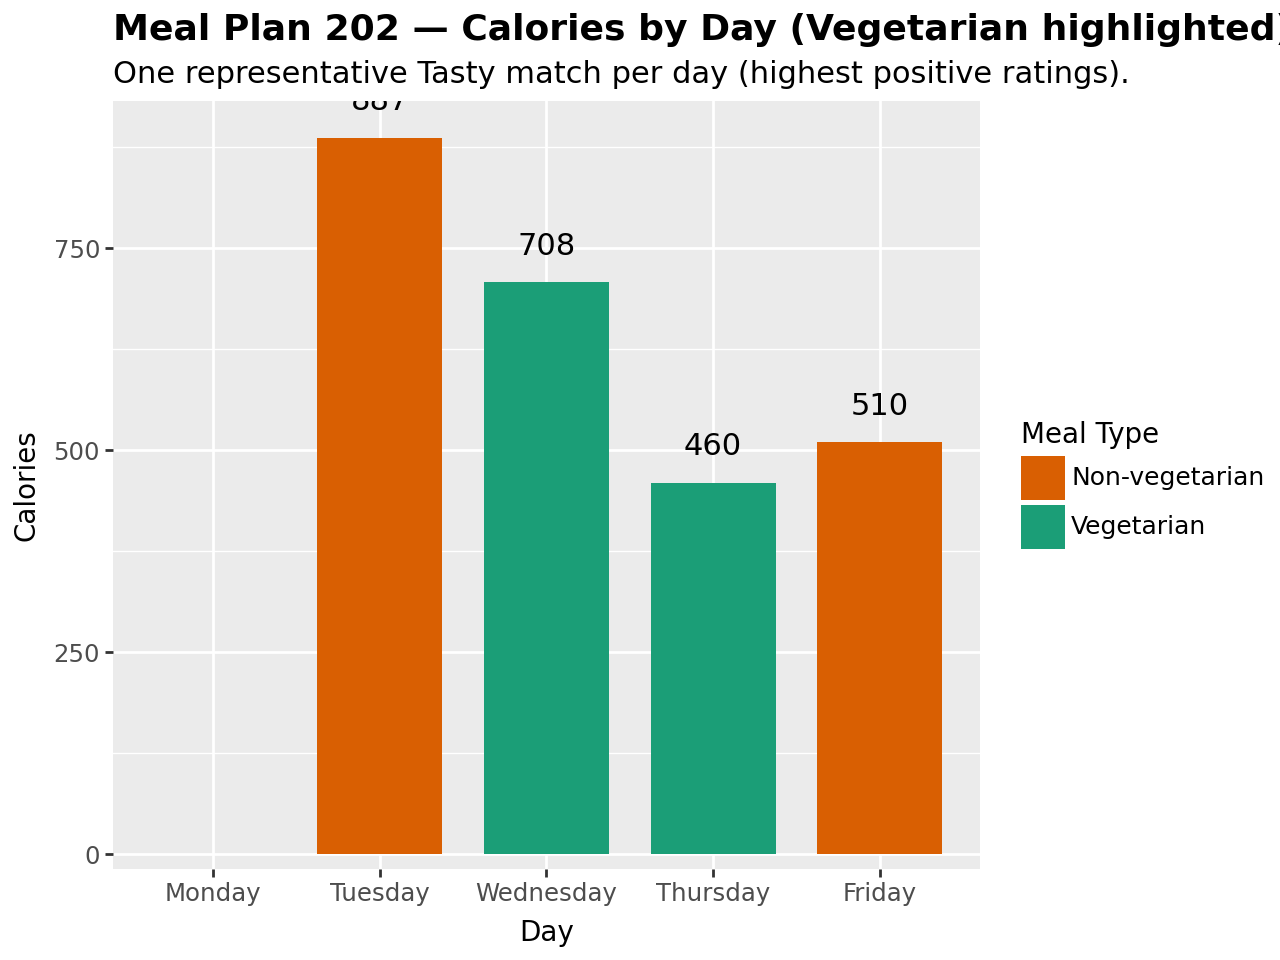